In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
plt.style.use('bmh')

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
DATA_DIR = '/home/mondzi259/Apna_Assignment/data/'

In [8]:
df = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=0)
df.shape

(30000, 19)

In [9]:
data_dic = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=1,header=None)

In [10]:
data_dic

,0,1,2,3
0,lead,A candidate who has interacted with HR on the ...,NaN,NaN
1,shift,night/ day,"0 - day, 1 - night",NaN
2,gender,f/m/all,"0 - male jobs, 1 - female , 2 - all",NaN
3,education,10th to PG,"ordinally placed, 10th being lowest and PG the...",NaN
4,created_on,job created date,Days since a fixed reference data,"For ex: if reference data was 1 Jan 2020,\njob..."
5,employer_type,key-account/ smb/ enterprise/ consultant/ NA,"most jobs are smb, followed by Key accounts, e...",NaN
6,applicant_location,candidate distance from job,"lower the value, lower the distance requirement",NaN
7,city,city,is masked,NaN
8,area,area,is masked,NaN
9,organization,company name,is masked,NaN


In [11]:
def plot_bar(y,title,xlabel,ylabel,figsize=(15,5),text_shift=1):
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(y.index, y, height=0.75, color="blue",alpha=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for i, v in enumerate(y):
        ax.text(v + text_shift, i, str(v), color='black', fontsize=10, va='center')
    plt.show()

### Null/Missing values

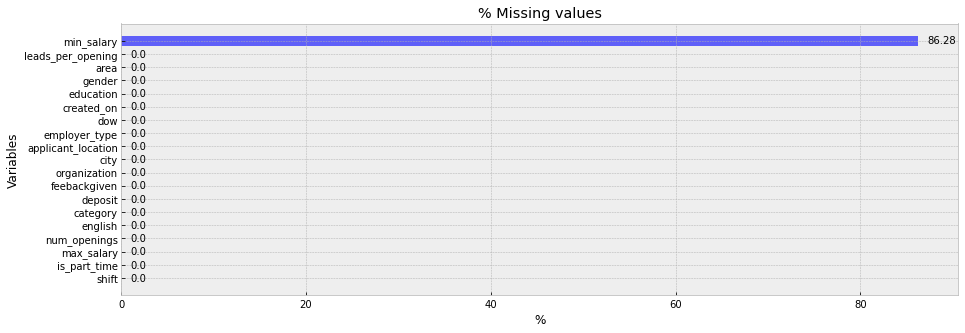

In [12]:
plot_bar((100*df.isnull().sum()/df.shape[0]).round(2).sort_values(ascending=True),
         '% Missing values','%','Variables')

In [13]:
df.min_salary.isnull().sum()

25883

##### Only column with null values: min_salary with 86.28% null

### Duplicate/Jobs with exact same data: 44

In [14]:
df.duplicated().value_counts()

False    29956
True        44
dtype: int64

### Incorrect data/data quality issues: 

In [15]:
(df.max_salary<df.min_salary).value_counts()

False    29999
True         1
dtype: int64

In [16]:
df[df.max_salary<df.min_salary]

,shift,gender,education,created_on,dow,employer_type,applicant_location,city,area,organization,deposit,category,english,num_openings,max_salary,min_salary,is_part_time,feebackgiven,leads_per_opening
25744,0.0,0.0,0.0,491.0,6.0,3.0,1.0,5.0,2193.0,29300.0,0.0,16.0,4.0,50.0,18000.0,20000.0,1.0,1.0,0.16


In [17]:
_=df.groupby('area')['city'].nunique()
_.index[_>1].shape,df[df.area.isin(_.index[_>1])].shape

((10,), (154, 19))

##### 1. Cases where max salary is less than min salary: 1 data point
##### 2. There can be multiple areas within a city but ideally 1 area should belong to one city only. There are 10 areas for which multiple cities are alloted: 154 data points

In [18]:
df[(df.feebackgiven==1) &(df['leads_per_opening']<1)].shape

(1083, 19)

##### Ideally for a job if feebackgiven==1, this means the job has been filled/closed by the employer, which means if the job is filled through Apna's platform, num_leads>=num_openings, hence, leads_per_opening>=1. Hence, if leads_per_opening < 1 means the job has been filled through some other source/platform or it's closed or there is a data capture issue. Either the job is closed through another platform or the number of hires is less than the number of openings: 1083 data points 

### Unique values plot

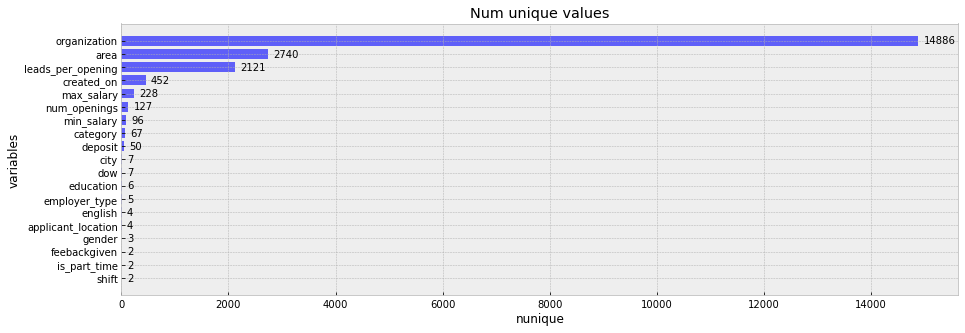

In [19]:
plot_bar(df.nunique().sort_values(ascending=True),'Num unique values','nunique','variables',text_shift=100)

##### Organization and area are categorical columns with very high number of unique values.

### Splitting into num and cat (ordinal/non ordinal) cols

In [20]:
num_cols = ['leads_per_opening','max_salary','min_salary','deposit','num_openings','created_on']
cat_cols = list(set(df.columns.tolist())-set(num_cols))
cat_ordinal_cols = ['applicant_location','english','education']
cat_non_ord_cols = [i for i in cat_cols if i not in cat_ordinal_cols]
large_cat_cols = ['organization','area','category']
cat_distribution_cols = [i for i in cat_ordinal_cols + cat_non_ord_cols if i not in large_cat_cols]

In [21]:
num_cols

['leads_per_opening',
 'max_salary',
 'min_salary',
 'deposit',
 'num_openings',
 'created_on']

In [22]:
cat_ordinal_cols,cat_non_ord_cols

(['applicant_location', 'english', 'education'],
 ['shift',
  'feebackgiven',
  'city',
  'employer_type',
  'gender',
  'dow',
  'category',
  'area',
  'organization',
  'is_part_time'])

###### NOTE: Some people could treat dow as ordinal such that when dow is increasing, we're approaching the weekend.

### Cat cols distribution

In [23]:
for i in cat_cols:
    print("Variable: {} \nfrequency distribution: \n{} \n----".format(i,df[i].value_counts(1).iloc[:7]))

Variable: applicant_location 
frequency distribution: 
0.0    0.862767
1.0    0.077067
2.0    0.035567
3.0    0.024600
Name: applicant_location, dtype: float64 
----
Variable: shift 
frequency distribution: 
0.0    0.981167
1.0    0.018833
Name: shift, dtype: float64 
----
Variable: feebackgiven 
frequency distribution: 
0.0    0.892333
1.0    0.107667
Name: feebackgiven, dtype: float64 
----
Variable: city 
frequency distribution: 
2.0    0.349867
4.0    0.262333
1.0    0.172600
5.0    0.107233
3.0    0.048833
0.0    0.045700
6.0    0.013433
Name: city, dtype: float64 
----
Variable: employer_type 
frequency distribution: 
4.0    0.556467
0.0    0.192433
1.0    0.145800
3.0    0.102500
2.0    0.002800
Name: employer_type, dtype: float64 
----
Variable: gender 
frequency distribution: 
0.0    0.922467
2.0    0.050733
1.0    0.026800
Name: gender, dtype: float64 
----
Variable: dow 
frequency distribution: 
2.0    0.164800
0.0    0.163867
1.0    0.163533
3.0    0.152500
4.0    0.151600


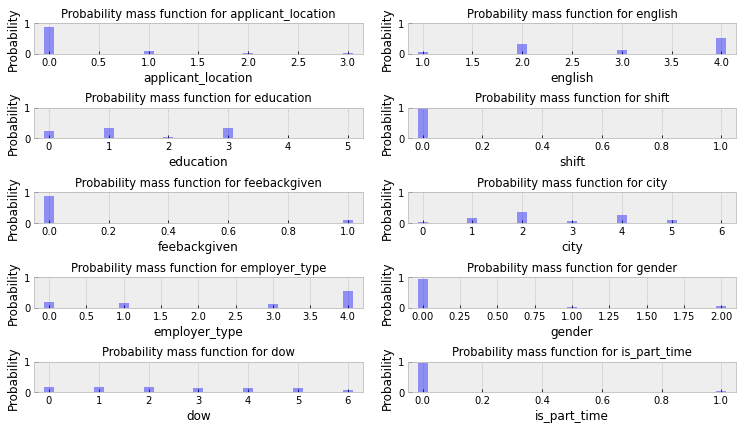

In [24]:
fig, axes = plt.subplots(round(len(cat_distribution_cols) / 2), 2, figsize=(10.5, 6))

for i,ax in enumerate(fig.axes):
    if i<len(cat_distribution_cols):
        counts = df[cat_distribution_cols[i]].value_counts(1)
        values = counts.index
        ax.vlines(values, 0,counts, color='blue', lw=10,alpha=0.4)
        plt.rcParams.update({'font.size': 8})
        ax.set_title('Probability mass function for {}'.format(cat_distribution_cols[i]))
        ax.set_xlabel(cat_distribution_cols[i])
        ax.set_ylabel('Probability')
        ax.set_ylim(0,1)
fig.tight_layout()
plt.show()

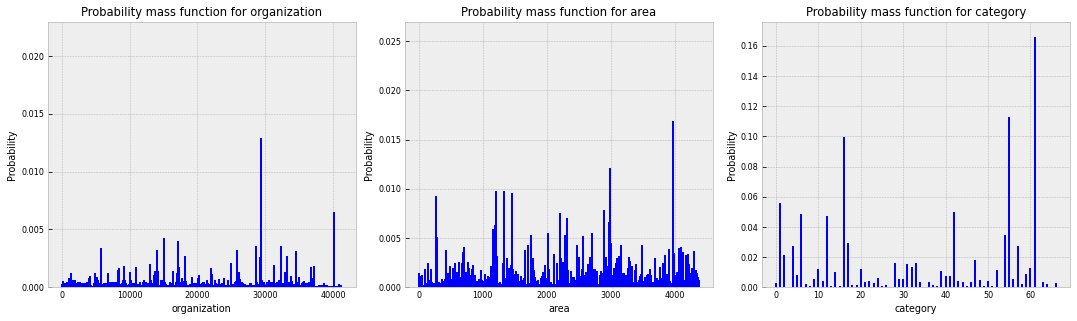

In [25]:
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(round(len(large_cat_cols) / 3), 3, figsize=(15, 4.5))

for i,ax in enumerate(fig.axes):
        counts = df[large_cat_cols[i]].value_counts(1)
        values = counts.index
        ax.vlines(values, 0,counts, color='blue', lw=2)
        ax.set_title('Probability mass function for {}'.format(large_cat_cols[i]))
        ax.set_xlabel(large_cat_cols[i])
        ax.set_ylabel('Probability')
        ax.set_ylim(0,np.max(counts)+0.01)
fig.tight_layout()

In [26]:
df.groupby('organization').feebackgiven.mean().sort_values(ascending=False).describe()

count    14886.000000
mean         0.108186
std          0.281835
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: feebackgiven, dtype: float64

In [27]:
df.groupby('area').feebackgiven.mean().sort_values(ascending=False).describe()

count    2740.000000
mean        0.126008
std         0.236948
min         0.000000
25%         0.000000
50%         0.000000
75%         0.143601
max         1.000000
Name: feebackgiven, dtype: float64

In [28]:
orgz = df.groupby('organization').feebackgiven.mean().sort_values(ascending=False)
orgz[orgz>0.7].shape,orgz[orgz==1].shape,orgz.shape,orgz[orgz==1].shape[0]/orgz.shape[0]

((1164,), (1154,), (14886,), 0.07752250436651888)

In [29]:
df.organization.isin(orgz[orgz==1].index).value_counts(1)

False    0.958233
True     0.041767
Name: organization, dtype: float64

In [30]:
df[df.organization.isin(orgz[orgz==1].index)]['city'].value_counts(1)

2.0    0.355946
4.0    0.247406
1.0    0.148444
5.0    0.122107
3.0    0.058260
0.0    0.044693
6.0    0.023144
Name: city, dtype: float64

In [31]:
areas = df.groupby('area').feebackgiven.mean().sort_values(ascending=False)
areas[areas>0.7].shape,areas[areas==1].shape,areas.shape,areas[areas==1].shape[0]/areas.shape[0]

((133,), (132,), (2740,), 0.04817518248175182)

In [32]:
df.area.isin(areas[areas==1].index).value_counts(1)

False    0.994967
True     0.005033
Name: area, dtype: float64

In [33]:
df[df.area.isin(areas[areas==1].index)]['city'].value_counts(1)

4.0    0.311258
2.0    0.185430
1.0    0.158940
0.0    0.125828
5.0    0.125828
6.0    0.072848
3.0    0.019868
Name: city, dtype: float64

In [34]:
df.groupby('area').organization.nunique().describe()

count    2740.000000
mean        7.746350
std        17.013994
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max       271.000000
Name: organization, dtype: float64

In [35]:
df.groupby('city').organization.nunique().describe()

count       7.000000
mean     2252.714286
std      1835.880598
min       262.000000
25%       898.000000
50%      1939.000000
75%      3143.000000
max      5486.000000
Name: organization, dtype: float64

In [36]:
(df.groupby('city').area.nunique()/df.area.nunique()).sort_values(ascending=False).cumsum()

city
4.0    0.256934
2.0    0.482117
1.0    0.677737
5.0    0.837226
0.0    0.937226
3.0    0.979197
6.0    1.004380
Name: area, dtype: float64

In [37]:
df.city.value_counts(1)

2.0    0.349867
4.0    0.262333
1.0    0.172600
5.0    0.107233
3.0    0.048833
0.0    0.045700
6.0    0.013433
Name: city, dtype: float64

In [38]:
cat_means = df.groupby('category').feebackgiven.mean()
cat_means.describe()

count    67.000000
mean      0.108008
std       0.058368
min       0.000000
25%       0.075856
50%       0.107527
75%       0.160377
max       0.221557
Name: feebackgiven, dtype: float64

In [39]:
(cat_means==0).value_counts(1)

False    0.895522
True     0.104478
Name: feebackgiven, dtype: float64

In [40]:
df[df.category.isin(cat_means[(cat_means==0)].index)].shape[0]/df.shape[0]

0.0033

###### 1. Only uniform type distribution (discrete) variable: dow
###### 2. All other variables are skewed towards certain values.
###### 3. dow: Assuming the use of python weekday function, 0: Monday and 6: Sunday.
###### 4. gender: Most jobs require male candidates {0:'male',1:'female',2:'all'}
###### 5. applicant_location: Jobs generally requires applicant to be closer to the job area
###### 6. english: {4:'fluent',3:'good-english',2:'broken-english',1:'no english requirement'}. Half (50%) of the jobs require fluent english requirement. Only 6% of the jobs require candiates with no english requirement.
###### 7. city: 7 Indian cities account for all the jobs and 60% jobs are from 2/7 cities and 80% jobs from 3/7 cities. Top 3 cities account for 70% of the areas.
###### 8. is_part_time: {1:'part_time',0:'full_time'}. 96% jobs have full time requirements.
###### 9. shift: {0:'day',1:'night'}. 98% day jobs
###### 10. education: {0:'10th',5:'PG'}. Values 1-4 maybe 11,12,UG,etc. 97% jobs require education requirements<=UG. Hence, blue and grey collar jobs (Apna's market).
###### 11. feebackgiven: Majority (89%) jobs are not closed and hence, still open.
###### 12. employer type: {4:'smb',0:'key accounts',1:'enterprise',3:'consultant',2:'na'}. 56% jobs have smb employers.
###### 13. Jobs (4.2% of total) for around 7.8% of the organizations have always closed(feebackgiven==1)
###### 14. Jobs (0.5% of total) for around 4.8% of the areas have always closed(feebackgiven==1)
###### 15. On an average, average number of jobs closed at a category level(driver/delivery boy etc) is 11%. 7/67 (10.5%) categories have all jobs open.

### Num cols distribution

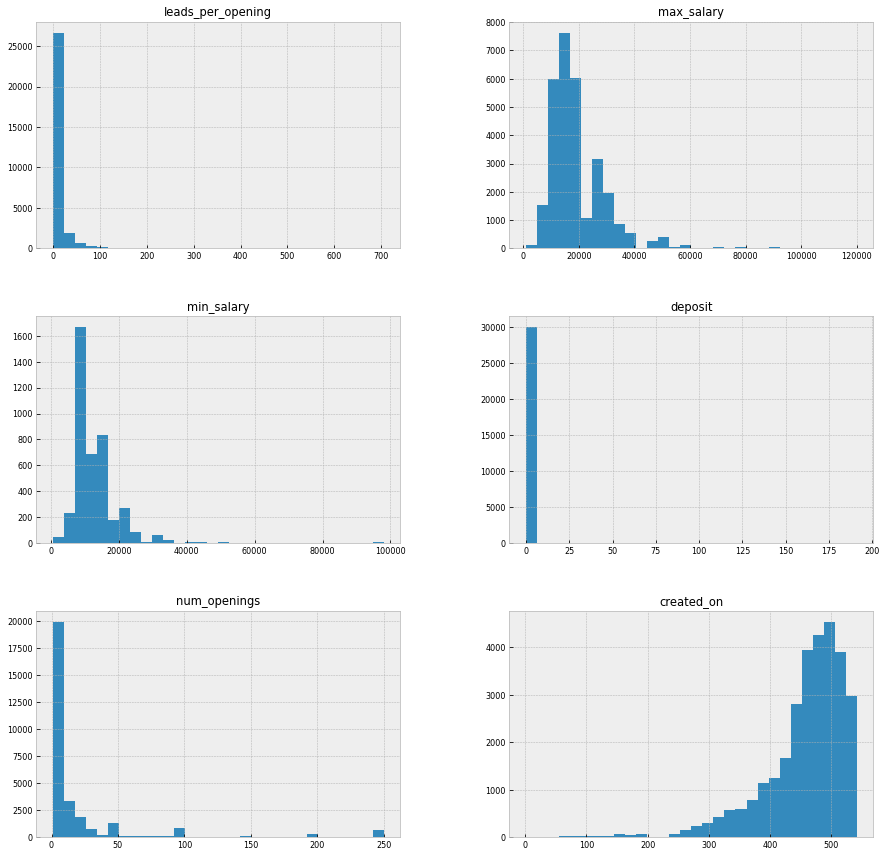

In [41]:
df[num_cols].hist(figsize=(15, 15), bins=30, xlabelsize=8, ylabelsize=8)
plt.show()

In [42]:
df[num_cols].skew()

leads_per_opening     7.379424
max_salary            2.427513
min_salary            3.994122
deposit              28.635632
num_openings          3.743297
created_on           -1.948968
dtype: float64

In [43]:
(df.deposit==0).value_counts(1)

True     0.9981
False    0.0019
Name: deposit, dtype: float64

In [44]:
df[num_cols].describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,leads_per_opening,max_salary,min_salary,deposit,num_openings,created_on
count,30000.000000,30000.000000,4117.000000,30000.000000,30000.000000,30000.000000
mean,10.520237,19311.095233,12789.478504,0.199267,19.856867,456.414133
std,24.666360,10449.799091,6644.144473,5.087870,45.675095,69.075763
min,0.000000,1000.000000,500.000000,0.000000,1.000000,1.000000
1%,0.000000,5000.000000,3000.000000,0.000000,1.000000,185.000000
5%,0.000000,8000.000000,6000.000000,0.000000,1.000000,323.000000
10%,0.000000,10000.000000,7500.000000,0.000000,1.000000,367.000000
25%,0.469847,12000.000000,10000.000000,0.000000,1.000000,433.000000
50%,2.666667,16000.000000,12000.000000,0.000000,3.000000,473.000000
75%,10.000000,25000.000000,15000.000000,0.000000,10.000000,503.000000


###### 1. All numeric variables except created_on are skewed towards right.
###### 2. deposit=0 for majority (99.8%) of customers. Most jobs don't have a deposit requirement.
###### 3. 90% of the job postings have <=50 openings.
###### 4. Presence of outliers can be seen in variables.
###### 5. Outlier examples: 
    a. In leads_per_opening, we can say that there are outliers with values >~50. 
    b. Similarly, max salary >~50k/60k also accounts for outliers. 
    c. In created_on, values <~250/300 belong to the outliers pool.

### Relation between num cols

In [45]:
df[df.min_salary.notnull()][num_cols].corr()['min_salary']

leads_per_opening   -0.052415
max_salary           0.792076
min_salary           1.000000
deposit              0.050441
num_openings         0.109167
created_on           0.021981
Name: min_salary, dtype: float64

In [46]:
df.groupby(df.min_salary.isnull())['max_salary','min_salary'].describe()

max_salary                                                                          min_salary                                                                      
                count          mean           std     min      25%      50%      75%       max      count          mean          std    min      25%      50%      75%      max
min_salary                                                                                                                                                                     
False          4117.0  18894.283945  10238.846261  1000.0  12000.0  16000.0  22000.0   99999.0     4117.0  12789.478504  6644.144473  500.0  10000.0  12000.0  15000.0  98000.0
True          25883.0  19377.394042  10481.628974  1000.0  12000.0  16000.0  25000.0  120000.0        0.0           NaN          NaN    NaN      NaN      NaN      NaN      NaN

#### correlation matrix and heat map

In [47]:
corrmat = df[[i for i in num_cols if i not in ['min_salary']]].corr()
corrmat

,leads_per_opening,max_salary,deposit,num_openings,created_on
leads_per_opening,1.000000,-0.057063,-0.014096,-0.158704,0.017885
max_salary,-0.057063,1.000000,0.036485,0.211193,0.051165
deposit,-0.014096,0.036485,1.000000,0.052897,0.017079
num_openings,-0.158704,0.211193,0.052897,1.000000,0.031405
created_on,0.017885,0.051165,0.017079,0.031405,1.000000


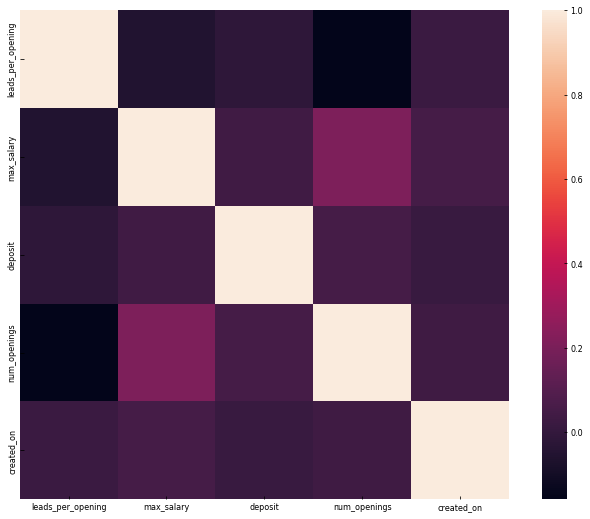

In [48]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

In [49]:
def decile_plot(_,y,num_cols = 2,figsize=(10, 7)):
    fig, axes = plt.subplots(round(len(_)/num_cols), num_cols, figsize=figsize)
    for i,ax in enumerate(fig.axes):
        if _[i]=='deposit':
            df.groupby((df.deposit>0).astype('int'))[y].mean().plot(ax=ax)
        else:
            df.groupby(pd.qcut(df[_[i]],10,duplicates='drop',labels=False))[y].mean().plot(ax=ax)
    fig.tight_layout()

#### Pair wise Scatter and Decile plot

y=leads_per_opening

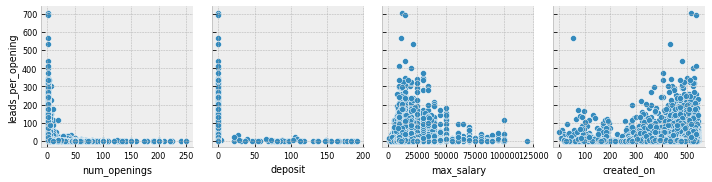

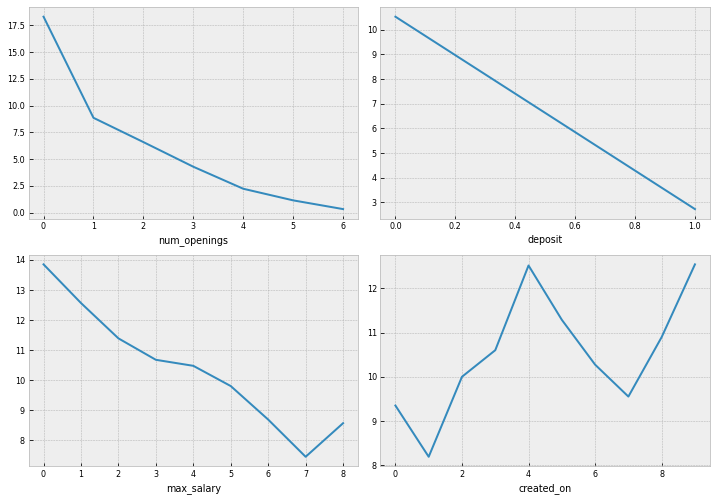

In [50]:
sns.pairplot(data=df,x_vars=list(set(num_cols)-set(['leads_per_opening','min_salary'])),
             y_vars=['leads_per_opening']);
decile_plot(list(set(num_cols)-set(['leads_per_opening','min_salary'])),y='leads_per_opening')

y=max_salary

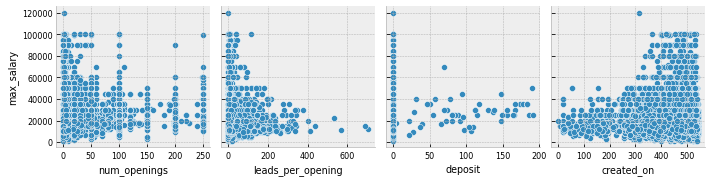

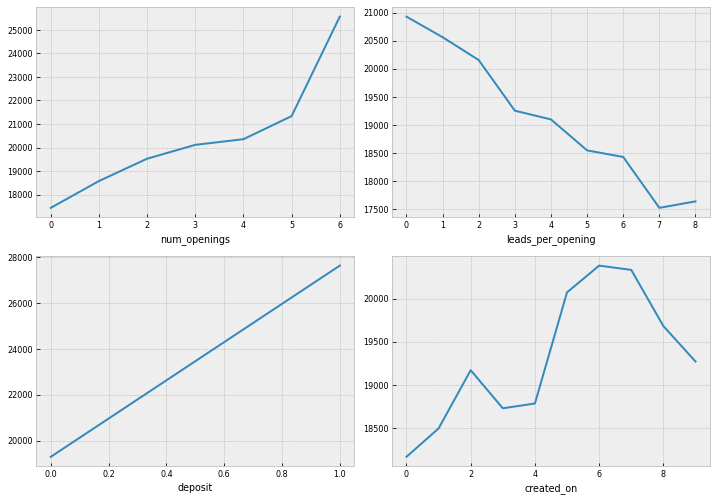

In [51]:
sns.pairplot(data=df,x_vars=list(set(num_cols)-set(['min_salary','max_salary'])),
             y_vars=['max_salary']);
decile_plot(_=list(set(num_cols)-set(['max_salary','min_salary'])),y='max_salary')

y=num_openings

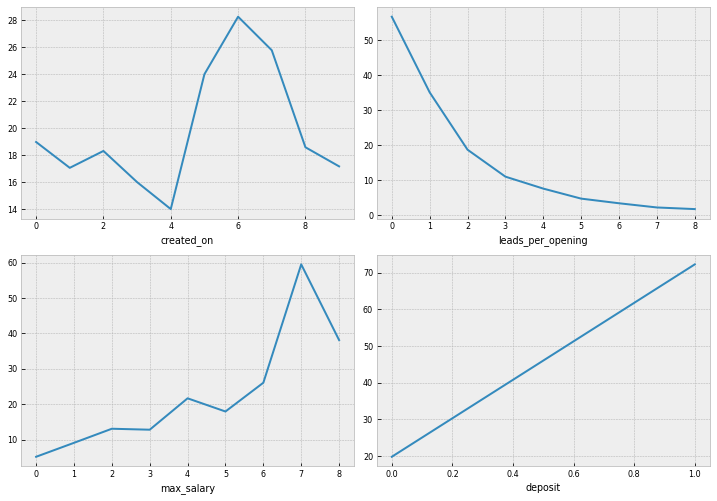

In [52]:
decile_plot(list(set(num_cols)-set(['num_openings','min_salary'])),y='num_openings')

In [53]:
df.groupby(df.min_salary.isnull())[num_cols+cat_ordinal_cols].nunique()

,leads_per_opening,max_salary,min_salary,deposit,num_openings,created_on,applicant_location,english,education
min_salary,,,,,,,,,
False,752,107,96,50,65,103,3,4,6
True,1978,212,0,1,124,452,1,4,6


In [54]:
df.applicant_location.value_counts()

0.0    25883
1.0     2312
2.0     1067
3.0      738
Name: applicant_location, dtype: int64

In [55]:
df.groupby(df.min_salary.isnull())['applicant_location'].value_counts()

min_salary  applicant_location
False       1.0                    2312
            2.0                    1067
            3.0                     738
True        0.0                   25883
Name: applicant_location, dtype: int64

In [56]:
for i in num_cols+cat_ordinal_cols:
    if i !='min_salary':
        print(i,'stats: \n',df.groupby(df.min_salary.isnull())[i].describe(),'\n---')

leads_per_opening stats: 
               count       mean        std  min    25%  50%   75%    max
min_salary                                                             
False        4117.0  14.612163  32.908250  0.0  0.450  4.0  15.5  705.0
True        25883.0   9.869367  23.019612  0.0  0.475  2.5   9.6  691.0 
---
max_salary stats: 
               count          mean           std     min      25%      50%      75%       max
min_salary                                                                                  
False        4117.0  18894.283945  10238.846261  1000.0  12000.0  16000.0  22000.0   99999.0
True        25883.0  19377.394042  10481.628974  1000.0  12000.0  16000.0  25000.0  120000.0 
---
deposit stats: 
               count      mean        std  min  25%  50%  75%    max
min_salary                                                         
False        4117.0  1.452028  13.669337  0.0  0.0  0.0  0.0  191.0
True        25883.0  0.000000   0.000000  0.0  0.0  0.0  0.0  

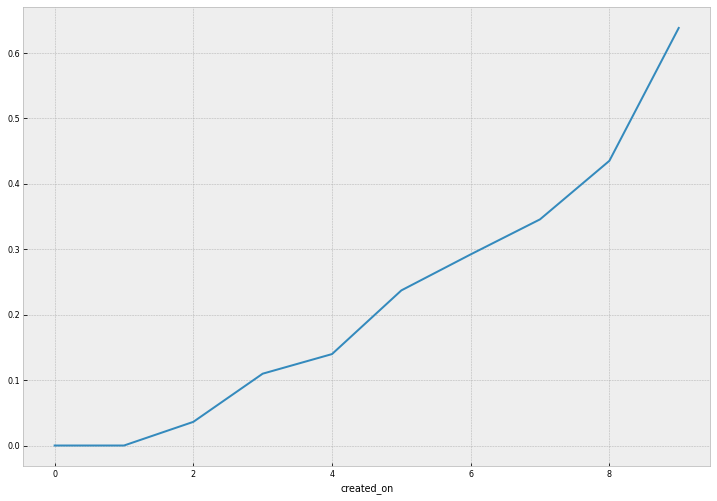

In [57]:
decile_plot(['created_on'],'applicant_location',1)

###### 1. For calculating correlation with min_salary, removing cases where values are null. As we expected min_salary is highly positively correlated with max_salary (80%).
###### 2. No numerical variables are very highly correlated. 
###### 3. While modeling, min_salary can be dropped as it has high % of missing values and also it is highly correlated to max_salary. Hence, large amount of the information represented by min_salary is captured by max_salary.
###### 4. With the decile plots/scatter plots/corr matrix, we can see some relationship between the numerical columns:
    a. As the max_salary and num_openings increases, leads_per_opening decreases. -ve correlation can be seen from the corr matrix as well.
    b. At a global level, as the created_on increases, which means further ahead we go from the reference date (later the job has been created), higher the leads_per_opening are => possible time series trend
    c. Weak correlation (0.21) can be seen between num_openings and max_salary. When a larger number of openings are floated by the employer, they tend to have higher salary.
    d. As the deposit increases to a non zero value, leads_per_opening decreases and salary increases. This makes sense as to reduction in engagement when candidates have to pay certain non zero money.
###### 5. min_salary is missing in all the cases/data points where applicant_location =0 or the applicant distance requirement is lowest. This could mean 2 things: min_salary was made to be zero intentionally in those cases for the purpose of EDA exercise or it's a data issue (whenever the candidate requirement is lowest in terms of distance, missing salary is not updated). I think a data issue is unlikely and looks like this was intentionally done for the purpose of EDA exercise. Last possibility could be that on the portal whenever employers/recruiters are setting applicant distance requirement as 0, specifying min_salary is not mandatory, this looks unlikley as well.
###### 6. When min_salary is missing/applicant distance requirement is lowest/less flexibility for the applying candidates in terms of distance: leads_per_opening tend to be lower (which makes sense), larger number of openings are provided. Also, created_on is lower, which means with increase in time, more flexible jobs have been starting to come up on the portal in terms of distance. (can be seen from the graph as well)

### Relation between Numerical and Categorical features

In [58]:
def plot_cat_num(_,y,num_cols=2,figsize=(11,18)):
    fig, axes = plt.subplots(round(len(_)/num_cols), num_cols, figsize=figsize)
    for i,ax in enumerate(fig.axes):
        df.groupby(_[i])[y].mean().plot.bar(ax=ax)
    fig.tight_layout()

#### Cat-Num Aggregate & Box plots

##### leads_per_opening vs cat_cols

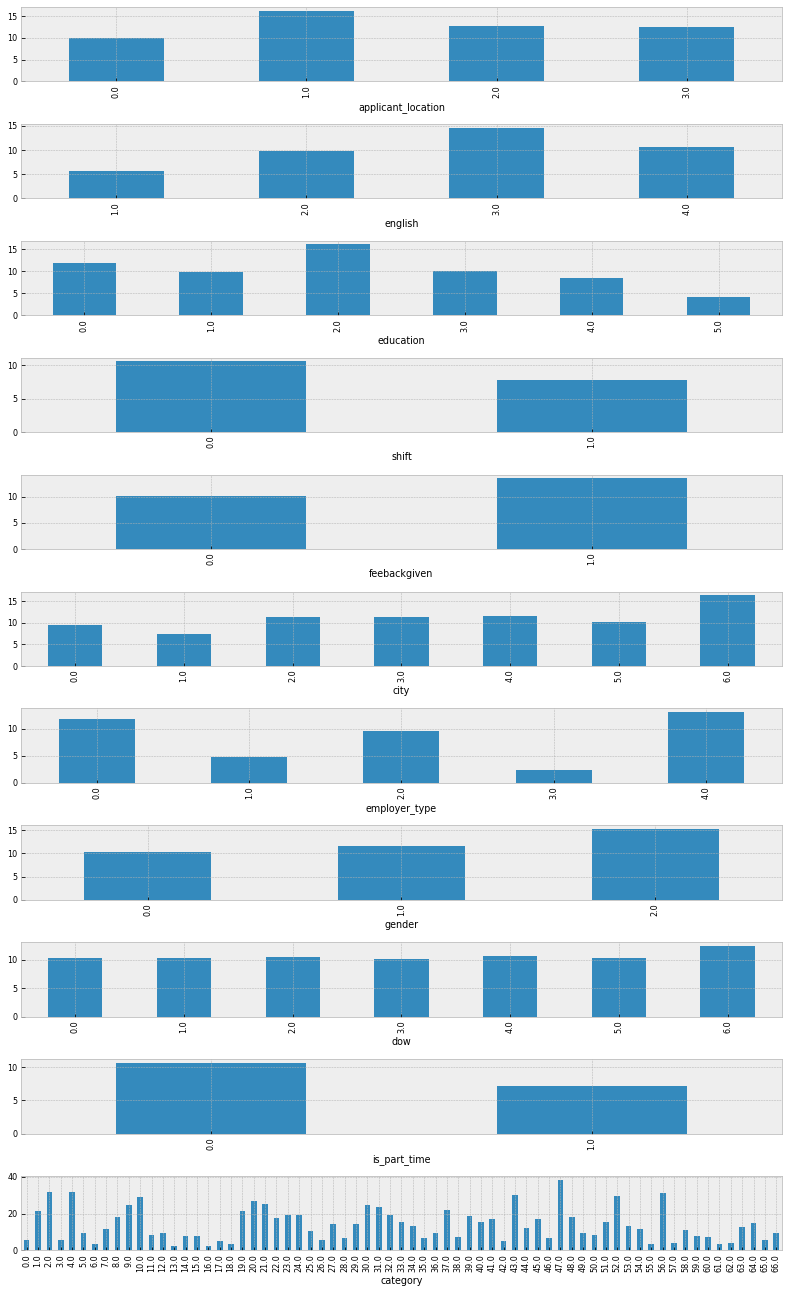

In [59]:
plot_cat_num(cat_distribution_cols+['category'],num_cols=1,y='leads_per_opening')

In [60]:
df.groupby('gender')['education'].mean()

gender
0.0    1.597384
1.0    1.748756
2.0    1.072273
Name: education, dtype: float64

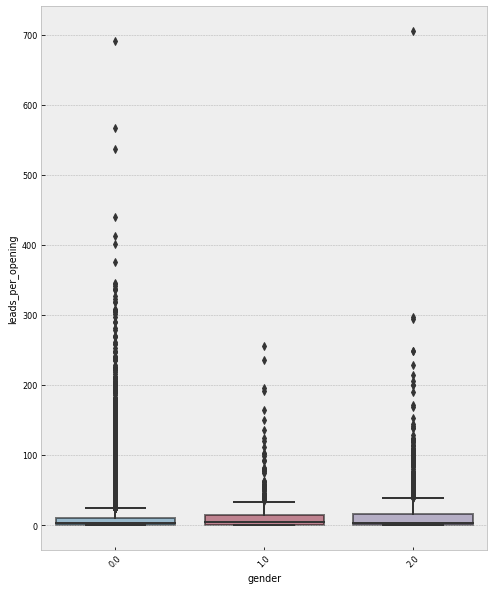

In [61]:
plt.figure(figsize = (8, 10))
ax = sns.boxplot(x='gender',y='leads_per_opening',data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45);

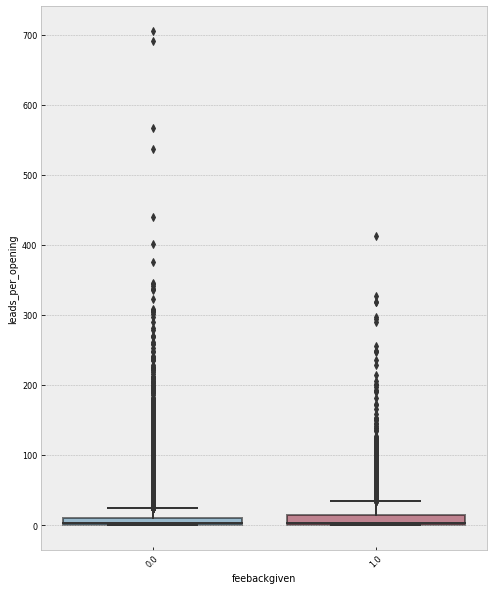

In [62]:
plt.figure(figsize = (8, 10))
ax = sns.boxplot(x='feebackgiven',y='leads_per_opening',data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45);

##### max_salary vs cat_cols

In [63]:
df.groupby('english')['max_salary'].median()

english
1.0    20000.0
2.0    18000.0
3.0    14783.5
4.0    15000.0
Name: max_salary, dtype: float64

In [64]:
df.groupby('shift').max_salary.describe()

,count,mean,std,min,25%,50%,75%,max
shift,,,,,,,,
0.0,29435.0,19313.964906,10437.034707,1000.0,12000.0,16000.0,25000.0,120000.0
1.0,565.0,19161.592920,11103.278585,3000.0,12000.0,17000.0,25000.0,99000.0


In [65]:
df.groupby('employer_type').max_salary.describe()

,count,mean,std,min,25%,50%,75%,max
employer_type,,,,,,,,
0.0,5773.0,18482.148969,9995.446294,1000.0,12000.0,15000.0,21000.0,99999.0
1.0,4374.0,22263.007087,11659.679899,2000.0,15000.0,20000.0,25000.0,99999.0
2.0,84.0,19776.190476,10494.136275,3000.0,15000.0,18000.0,23500.0,90000.0
3.0,3075.0,23597.739837,10294.424378,1200.0,15000.0,22000.0,30000.0,99999.0
4.0,16694.0,18032.392956,9923.497768,1000.0,12000.0,15000.0,20000.0,120000.0


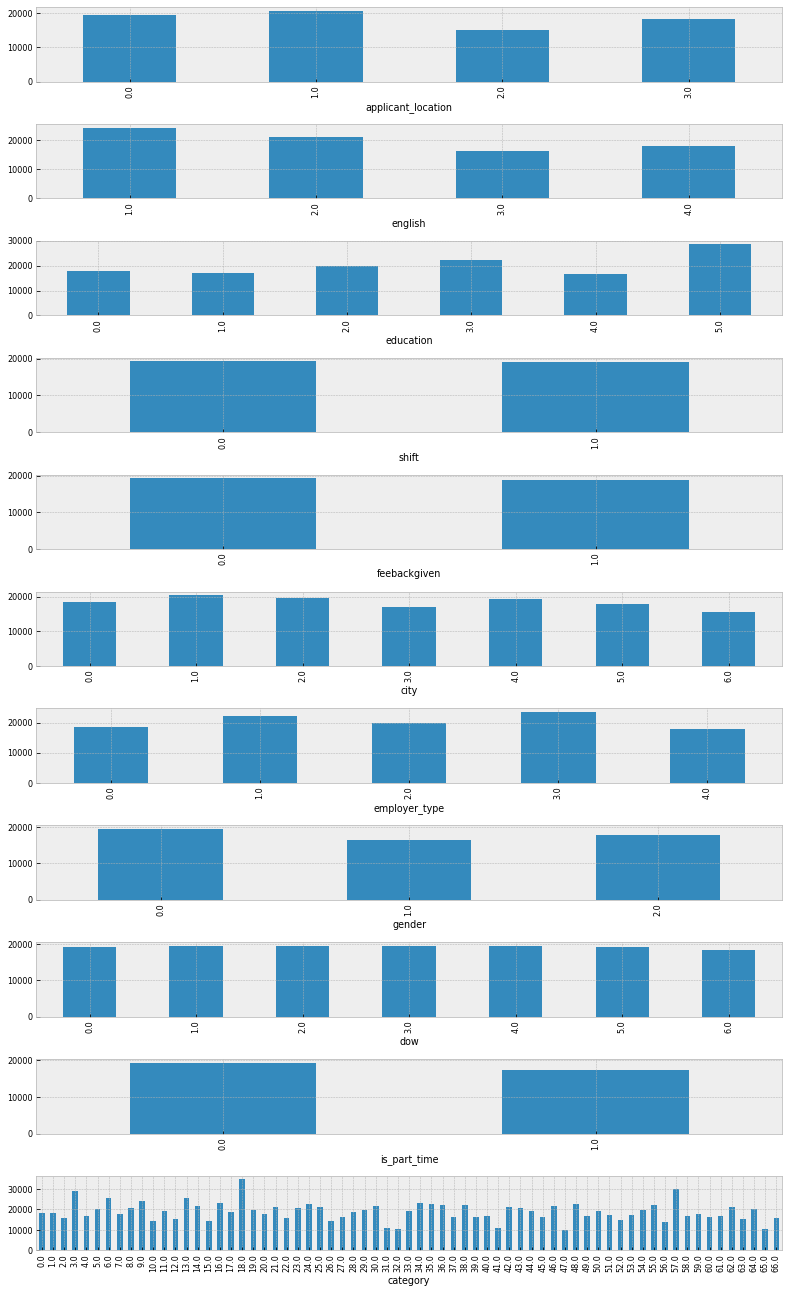

In [66]:
plot_cat_num(cat_distribution_cols+['category'],num_cols=1,y='max_salary')

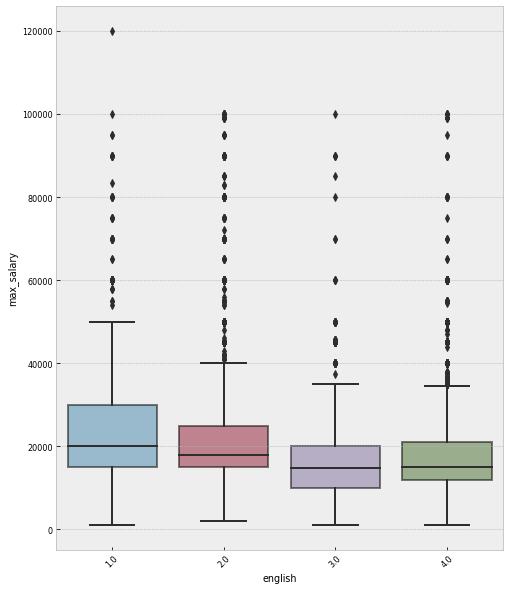

In [67]:
plt.figure(figsize = (8, 10))
ax = sns.boxplot(x='english',y='max_salary',data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45);

##### feebackgiven vs cat_cols

In [68]:
df.groupby('applicant_location').feebackgiven.describe()

,count,mean,std,min,25%,50%,75%,max
applicant_location,,,,,,,,
0.0,25883.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1.0,2312.0,0.775087,0.417616,0.0,1.0,1.0,1.0,1.0
2.0,1067.0,0.782568,0.412692,0.0,1.0,1.0,1.0,1.0
3.0,738.0,0.817073,0.386869,0.0,1.0,1.0,1.0,1.0


In [69]:
df.groupby(['applicant_location']).leads_per_opening.describe()

,count,mean,std,min,25%,50%,75%,max
applicant_location,,,,,,,,
0.0,25883.0,9.869367,23.019612,0.0,0.475000,2.500000,9.600,691.0
1.0,2312.0,16.223283,37.288156,0.0,0.400000,3.800000,16.600,705.0
2.0,1067.0,12.583595,24.645679,0.0,0.500000,4.000000,15.000,294.0
3.0,738.0,12.497763,28.125875,0.0,0.454167,3.853571,12.375,297.0


In [70]:
df.groupby('gender').feebackgiven.describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
0.0,27674.0,0.052215,0.222464,0.0,0.0,0.0,0.0,1.0
1.0,804.0,0.726368,0.446100,0.0,0.0,1.0,1.0,1.0
2.0,1522.0,0.789093,0.408086,0.0,1.0,1.0,1.0,1.0


In [71]:
df.groupby('shift').feebackgiven.describe()

,count,mean,std,min,25%,50%,75%,max
shift,,,,,,,,
0.0,29435.0,0.107253,0.309440,0.0,0.0,0.0,0.0,1.0
1.0,565.0,0.129204,0.335722,0.0,0.0,0.0,0.0,1.0


In [72]:
df.groupby('is_part_time').feebackgiven.mean()

is_part_time
0.0    0.107845
1.0    0.103209
Name: feebackgiven, dtype: float64

In [73]:
df.groupby('employer_type').feebackgiven.describe()

,count,mean,std,min,25%,50%,75%,max
employer_type,,,,,,,,
0.0,5773.0,0.007448,0.085990,0.0,0.0,0.0,0.0,1.0
1.0,4374.0,0.182670,0.386440,0.0,0.0,0.0,0.0,1.0
2.0,84.0,0.095238,0.295307,0.0,0.0,0.0,0.0,1.0
3.0,3075.0,0.085203,0.279229,0.0,0.0,0.0,0.0,1.0
4.0,16694.0,0.126872,0.332839,0.0,0.0,0.0,0.0,1.0


In [74]:
df.groupby('education').feebackgiven.describe()

,count,mean,std,min,25%,50%,75%,max
education,,,,,,,,
0.0,7362.0,0.114507,0.318448,0.0,0.0,0.0,0.0,1.0
1.0,10470.0,0.106972,0.309093,0.0,0.0,0.0,0.0,1.0
2.0,1388.0,0.108069,0.310580,0.0,0.0,0.0,0.0,1.0
3.0,9735.0,0.104879,0.306414,0.0,0.0,0.0,0.0,1.0
4.0,432.0,0.097222,0.296604,0.0,0.0,0.0,0.0,1.0
5.0,613.0,0.088091,0.283659,0.0,0.0,0.0,0.0,1.0


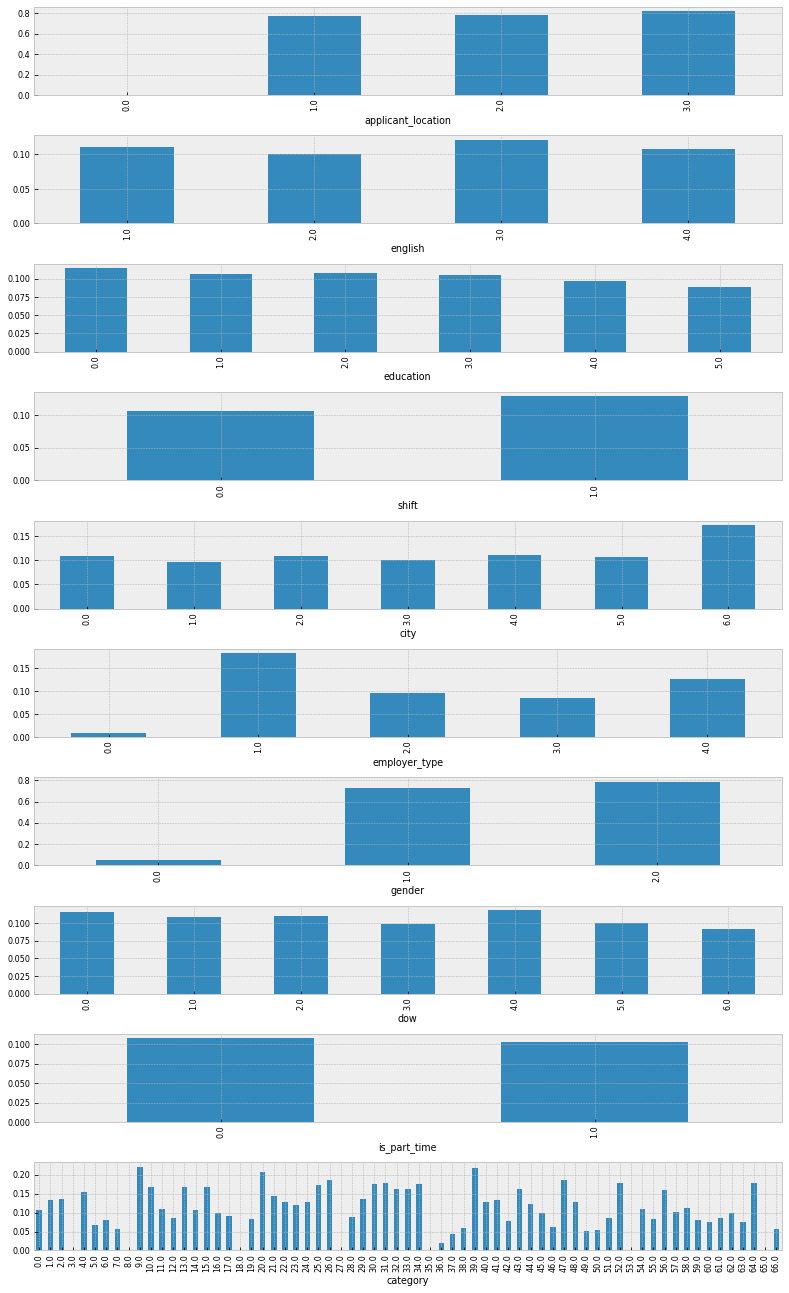

In [75]:
plot_cat_num([i for i in cat_distribution_cols+['category'] if i not in ['feebackgiven']],
             num_cols=1,y='feebackgiven')

##### feebackgiven vs num_cols

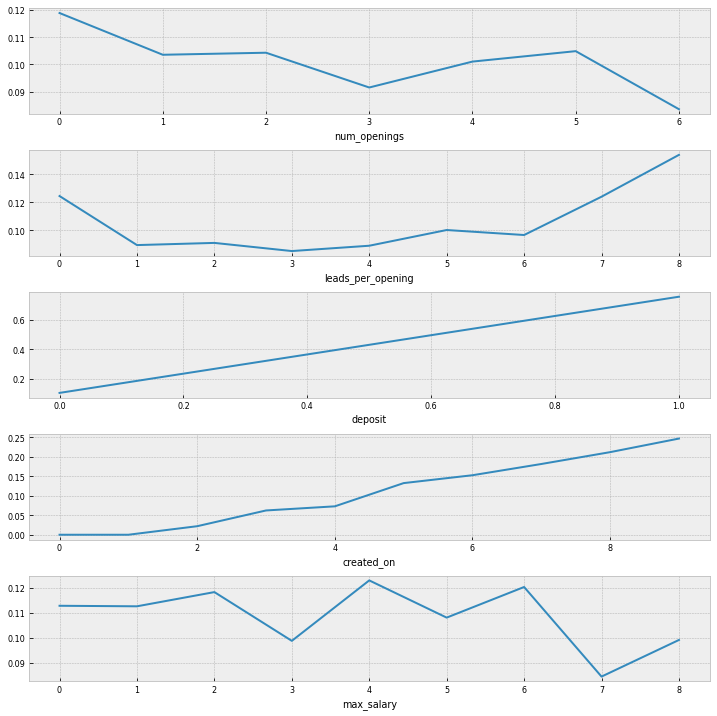

In [76]:
decile_plot(list(set(num_cols) - set(['min_salary'])),y='feebackgiven',num_cols = 1,figsize=(10,10))

##### correlation between ordinal cat cols and num cols

In [77]:
df[[i for i in num_cols+cat_ordinal_cols + ['feebackgiven'] if i not in ['min_salary']]].corr().iloc[:,-4:]

,applicant_location,english,education,feebackgiven
leads_per_opening,0.047447,0.036901,-0.031947,0.042339
max_salary,-0.038425,-0.166522,0.220712,-0.012561
deposit,0.067048,0.028964,-0.034522,0.077983
num_openings,-0.050570,0.126640,-0.256951,-0.038432
created_on,0.246901,-0.004362,0.029277,0.224304
applicant_location,1.000000,0.005935,-0.028559,0.782752
english,0.005935,1.000000,-0.425652,0.006175
education,-0.028559,-0.425652,1.000000,-0.013596
feebackgiven,0.782752,0.006175,-0.013596,1.000000


In [78]:
df.groupby('education')['english'].describe()

,count,mean,std,min,25%,50%,75%,max
education,,,,,,,,
0.0,7362.0,3.600924,0.556728,1.0,3.0,4.0,4.0,4.0
1.0,10470.0,3.228844,1.021485,1.0,2.0,4.0,4.0,4.0
2.0,1388.0,2.987752,1.040905,1.0,2.0,3.0,4.0,4.0
3.0,9735.0,2.457216,1.027660,1.0,2.0,2.0,4.0,4.0
4.0,432.0,3.449074,0.715878,1.0,3.0,4.0,4.0,4.0
5.0,613.0,2.058728,0.946170,1.0,1.0,2.0,2.0,4.0


###### 1. Jobs with higher english requirement tend to have more leads_per_opening; hence more engagement. Although as english requirements increase, salaries tend to decrease. This looks like a weird finding.
###### 2. As the education requirement increases, leads_per_opening decreases. This could be because since major candidates belong to grey/blue collar, hence less educated and hence more engagement when lesser education requirements. With increasing education requirements, more salaries are given which makes sense. As education requirement increases, chances of job getting closed decreases. This can be because the platform majorly has grey and blue collar workers.
###### 3. dow = Mon-Sat have ~ same enagement. But, job posting dow = Sunday has maximum engagement (maximum interaction of HR with candidates).
###### 4. Female type of jobs have more engagement. Male and both kind of jobs have higher salaries which shows a bias in the gender pay. Higher level of education requirement is there in female jobs as compared to male jobs. For females and all kind of jobs, probability of jobs getting closed increases. This can be attributed to female jobs having more engagement.
###### 5. Full time jobs have more engagement, are paid more and have a slightly higher probability of getting closed.
###### 6. Day shift jobs have more engagement. Night shift jobs have a higher min and median salary which can make sense because it's an odd hour shift. Night jobs have more probabilty of getting closed. But since they have a very less count, this could be a wrong finding as well.
###### 7. leads_per_opening are higher when feebackgiven=1. Essentially meaning that closed jobs have higher engagement which means majority jobs on the Apna platform are closed through the platform only as compared to outside.
###### 8. smb and key account jobs tend to have higher engagement. Enterprise and consultant jobs pay the most. Enterprise and smb jobs close more as compared to other jobs. Could be driven by the fact that smb has high engagement.
###### 9. With lower distance requirements, salaries are generally higher. As applicant distance requirement increases (more flexibility to applying candidates), chances of jobs getting closed(feebackgiven=1) increases and also can be seen that they have a very high correlation (0.78). With higher application distance requirements since leads_per_opening increase, hence chances of jobs getting closed increases.
###### 10. City 6 has the highest engagement and hence, also has the highest probability of getting closed. But, it provides the lowest salary with lowest proportion (1.3%) of total jobs. 
###### 11. As the job created date increases, probability of jobs closing increases. This could be because leads_per_opening increases and also maybe a time series trend in the data that, with time, job closing probability increases which is good for Apna because that will correspond to increase in revenue as well.
###### 12. With increasing number of openings, less jobs close. This could be because leads_per_opening decrease.
###### 13. Higher education requirements correspond to lower english requirements which is a little confusing. One hypothesis is that, if education requirements are high, candidate can have a little poor english. So, poor english being compensated by higher education.

-----

#### Some variables that might be of predictive interest are: leads_per_opening, feebackgiven, max_salary 

-------

# Problem Statement Ideas:


#### 1. Given a job posting and its related variables, predict the number of leads_per_opening. Higher this number, means higher engagement will be seen for this job. Hence, more likely to recommend this job to the users. This problem could be treated as a regression problem or leads_per_opening could be converted to a binary/multiclass class (high engagement/low engagement/etc) and then the problem becomes the prediction of probability of engagement. Finally, from this analysis  important variables could also be suggested to employers on how they affect the engagement.
#### 2. Given a job posting, predict the probability of whether the job would be closed or not. Since feebackgiven =1 can be in the cases where num of hires>=0 and <=num_openings, which can also convey that the job is getting closed at another platform or the recruiter changed their mind about the hiring. By using a z score derived from feebackgiven and leads_per_opening, a joint target can be created which would essentially try to reduce/remove the bias towards a job closing from another platform/lesser number of hires than num_openings. Then a predictive model could be made on this joint target. [The output from the model can also be used to optimize Ads for jobs if Apna displays ads at other websites about the jobs listed on its platform.]
#### 3. Suggest the employer parameters for setting up a job posting to in order to maximize leads_per_opening/feebackgiven/joint target and hence engagement on the platform. This could be a constrained optimization problem with employer dynamically asking to recommend multiple job posting parameters (for eg.  max salary, distance requirements (applicant_location), english requirement, min salary, etc). This can be important from both employer as well as Apna's side because it would help employer maximize engagement for his job and also will help Apna maximize it's revenue per job posting by increasing engagement/probability of closing a job.
#### 4. Job posting segmentation to see which kind of jobs have higher engagement but serves a similar purpose as the engagement prediction problem (problem 1).

----